In [63]:
import numpy as np
import scipy as sp
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.linear_model import Lasso

from pyq.similarity import CosineSimilarity, Exponential_Cityblock_Similarity
from pyq.tree import build_binary_tree_by_median_split
from pyq.utils.scatter_3d import scatter_3d

from diffusion_map import DiffusionMap
from pyq.tree import HaarExpansion


#### Data Loading

In [64]:
file_path = '/Users/haiy/git/quests/questionnaire_matlab_legacy/examples/MMPI2_Depolarized.mat'
d = sp.io.loadmat(file_path)
data = d['matrix']
data_cols = d['points_dat']
data_rows = d['sensors_dat']
original_people_scores = d['original_people_scores']

#### Data preprocessing

In [65]:
vals,names=data_cols.squeeze().tolist()
names = [str(n[0]) for n in names.flatten().tolist()]


df_cols = pd.DataFrame(vals.T,columns=names)

df_rows = pd.DataFrame([[str(i[0])] for i in data_rows.squeeze().tolist()[0].flatten()],columns=['question'])

#### train-test split on the columns

In [66]:
test_size = 50
rng = np.random.default_rng(42)

test_idx = rng.choice(data.shape[1], size=test_size, replace=False)
train_idx = list(set(np.arange(data.shape[1])) - set(test_idx))

In [67]:
# make data is binary
# data[data==0] = -1


#### data is presented as follows

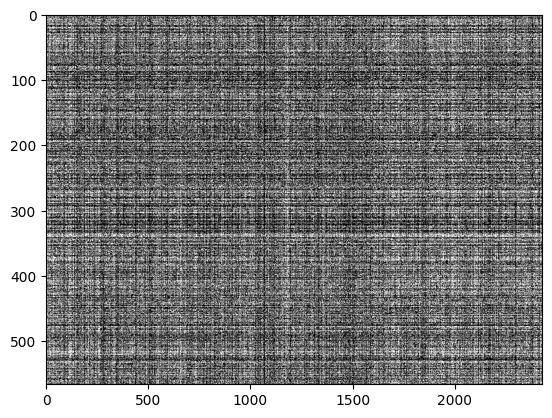

In [68]:
plt.imshow(data,cmap='gray',aspect='auto',vmin=0,vmax=1)
plt.show()

#### initial affinity for columns

In [69]:
col_sim = CosineSimilarity(threshold=0)(data.T)
col_tree = build_binary_tree_by_median_split(col_sim,min_size=2,max_depth=100)
col_emb = DiffusionMap(col_sim,n_dim=10).transform(1)

scatter_3d(col_emb,np.zeros(col_emb.shape[0]))

#### building the dual geometry 

In [70]:
# build the row tree based on the geometry on the columns
col_tree.compute_local_mean(data.T,'questionnaire')
col_tree.compute_inverse_cumsum('questionnaire')

row_emb = col_tree.compute_cumsum_expansion('questionnaire',l_end=9).T
row_sim = Exponential_Cityblock_Similarity()(row_emb)
row_tree = build_binary_tree_by_median_split(row_sim,min_size=1,max_depth=20)

/Users/haiy/git/quests/pyq/.venv/lib/python3.13/site-packages/diffusion_map/diffusion_embedding.py:124: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



In [71]:
n_eigs = 8
iter_dual_geom = 1
threshold = 0
time = 1
min_size = 2
max_depth = 100

l_end = 5

alpha = 0
beta = 0 

row_iters = []
col_iters = []


# build initial col tree
col_sim = CosineSimilarity(threshold=threshold)(data.T)
col_emb = DiffusionMap(col_sim,n_dim=n_eigs).transform(t=time)
col_tree = build_binary_tree_by_median_split(col_sim,min_size=min_size,max_depth=max_depth)

col_iters.append((col_sim,col_emb,col_tree))

# begin dual geometry iterations 
for i in range(iter_dual_geom):
    
    # update the rows
    _,_,col_tree = col_iters[-1]
    
    # compute the EMD embedding of rows based on the col tree
    col_tree.compute_local_mean(data.T,'questionnaire')
    col_tree.compute_inverse_cumsum('questionnaire')
    row_emb = col_tree.compute_cumsum_expansion('questionnaire',l_end=l_end, alpha=alpha, beta=beta).T    
    row_sim = Exponential_Cityblock_Similarity()(row_emb)
    row_emb = DiffusionMap(row_sim,n_dim=n_eigs).transform(t=time)
    row_tree = build_binary_tree_by_median_split(row_sim,min_size=min_size,max_depth=max_depth)
    row_iters.append((row_sim,row_emb,row_tree))
    
    # compute the EMD embedding of cols based on the row tree
    
    _,_,row_tree = row_iters[-1]
    row_tree.compute_local_mean(data,'questionnaire')
    row_tree.compute_inverse_cumsum('questionnaire')
    col_emb = row_tree.compute_cumsum_expansion('questionnaire',l_end=l_end, alpha=alpha, beta=beta).T
    col_sim = Exponential_Cityblock_Similarity()(col_emb)
    col_emb = DiffusionMap(col_sim,n_dim=n_eigs).transform(t=time)
    col_tree = build_binary_tree_by_median_split(col_sim,min_size=min_size,max_depth=max_depth)
    col_iters.append((col_sim,col_emb,col_tree))

---------

#### fitting the Haar expansion

In [72]:
_,_,col_tree = col_iters[-1]

In [73]:
haar = HaarExpansion(col_tree)
haar.funcs.shape

(2428, 1404)

#### prediction task: 

given a label, some of the label is observed, some of the label is un-observed, make prediction on the un-observed labels

In [74]:
Y = df_cols.values
Ytest = Y[test_idx]
Ytrain = Y[train_idx]

In [75]:
coefs_lasso =  Lasso(alpha=5e-4, fit_intercept=False).fit(haar.funcs[train_idx],Ytrain).coef_.T
print('density of lasso', np.mean(coefs_lasso!=0))
coefs_lstsq = np.linalg.lstsq(haar.funcs[train_idx],Ytrain,rcond=None)[0]


density of lasso 0.09528331750553973


In [76]:
Ypred_lasso = haar.funcs[test_idx] @ coefs_lasso
Ypred_lstsq = haar.funcs[test_idx] @ coefs_lstsq

In [77]:
mse_lasso = np.mean((Ytest - Ypred_lasso)**2)
mse_lstsq = np.mean((Ytest - Ypred_lstsq)**2)

mse_lasso,mse_lstsq

(np.float64(0.386762889804007), np.float64(0.7314969770087086))